In [8]:
#import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [40]:
# variables
batch_size = 32
img_size = 28 # MNIST Image size 28*28
patch_size = 7
num_channels = 1
num_patches = (img_size // patch_size) ** 2
num_attn_heads = 4
embed_dim = 16 #768
mlp_dim = 16 # hidden layers nodes
transformer_units = 1

In [42]:
# Transform PIL data to tensor
transform = transforms.Compose(
    [transforms.ToTensor()])

In [43]:
# load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
valset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

In [44]:
# create train and val batches
train_data = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
val_data = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)

Part 1: Embedding of ViT Transformer

In [45]:
# Embedded Patches
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size) # 32, 16, 16 Batch size, Patches, Embed_dim

    # x = input dataset
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2) # 3 dim
        x = x.transpose(1,2) # exchange dim between 1 and 2
        return x

In [46]:
# Check dimensions of data for testing
images, labels = next(iter(train_data))
print("Input Image Tensor Shape: ", images.shape)

patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
emb_img = patch_embed(images)
print("Input Image Tensor Shape after Conv2D: ", emb_img.shape)
print(emb_img.flatten(2).shape) # 3 dim -> 4,4 flatten to single 16 dim

print("Batch size, Patch size, Embed dim: ", emb_img.flatten(2).transpose(1,2).shape)

Input Image Tensor Shape:  torch.Size([32, 1, 28, 28])
Input Image Tensor Shape after Conv2D:  torch.Size([32, 16, 4, 4])
torch.Size([32, 16, 16])
Batch size, Patch size, Embed dim:  torch.Size([32, 16, 16])


Part 2: Transformer Encoder
- Layer 1 Norm, Mulit head attention, Layer 2 Norm, Residuals, MLP activation functions

In [39]:
# Transformer Encoder
class TransformerArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim) # norm on embed_dim
        self.self_attention = nn.MultiheadAttention(embed_dim, num_attn_heads, batch_first=True) # Emb dim/ attn heads = 16/4= 4 dims
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.multi_layer_perceptron = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        residual_1 = x # original value of embedding preserve in residuals
        attention_output = self.self_attention(self.layer_norm_1(x),self.layer_norm_1(x),self.layer_norm_1(x))[0]
        x = attention_output + residual_1
        residual_2 = x
        mlp_output = self.multi_layer_perceptron(self.layer_norm_2(x))
        x = mlp_output + residual_2
        return x


Part 3: MLP head for classifications

In [65]:
# class MLP_Head(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.layer_norm_1 = nn.LayerNorm(embed_dim)
#     self.mlp_head = nn.Sequential(
#         nn.Linear(embed_dim,num_channels)
#     )
#   def forward(x,self):
#     x = x[:,0]
#     x = self.layer_norm_1(x)
#     x = self.mlp_head(x)
#     return x

In [66]:
# Only use vector for CLS token for the MLP head classifications
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim)) # learnable params; 1=batch dim,1 vector
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim)) # learnable paramsl as many pos as many patches
        self.transformer_layers = nn.Sequential(*[TransformerArchitecture() for _ in range(transformer_units)]) # transformer encoder in series operations

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)
        )

    def forward(self,x):
        x = self.patch_embedding(x)
        B = x.size(0) # batch size shape;append cls tokens as many batch size given
        # create CLS tokens, and expand to batch dim
        cls_tokens = self.cls_token.expand(B , -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # concat cls token as the first elements
        x = x + self.pos_embed
        x = self.transformer_layers(x)
        x = x[:,0] # CLS token at pos 0
        x = self.mlp_head(x)
        return x

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [68]:
for epoch in range(2):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        preds = outputs.argmax(dim=1)

        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
  Batch   1: Loss = 2.4443, Accuracy = 6.25%
  Batch 101: Loss = 1.6784, Accuracy = 34.38%
  Batch 201: Loss = 1.3126, Accuracy = 53.12%
  Batch 301: Loss = 0.9747, Accuracy = 53.12%
  Batch 401: Loss = 1.2725, Accuracy = 56.25%
  Batch 501: Loss = 1.0489, Accuracy = 62.50%
  Batch 601: Loss = 0.7280, Accuracy = 71.88%
  Batch 701: Loss = 0.9758, Accuracy = 59.38%
  Batch 801: Loss = 1.2872, Accuracy = 62.50%
  Batch 901: Loss = 0.8309, Accuracy = 62.50%
  Batch 1001: Loss = 0.6200, Accuracy = 75.00%
  Batch 1101: Loss = 0.7322, Accuracy = 78.12%
  Batch 1201: Loss = 0.6814, Accuracy = 75.00%
  Batch 1301: Loss = 0.8457, Accuracy = 65.62%
  Batch 1401: Loss = 0.8421, Accuracy = 65.62%
  Batch 1501: Loss = 0.7583, Accuracy = 81.25%
  Batch 1601: Loss = 0.5911, Accuracy = 78.12%
  Batch 1701: Loss = 0.4515, Accuracy = 81.25%
  Batch 1801: Loss = 0.9187, Accuracy = 65.62%
==> Epoch 1 Summary: Total Loss = 1667.3340, Accuracy = 68.97%

Epoch 2
  Batch   1: Loss = 0.8062, Accuracy 

In [69]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 83.29%


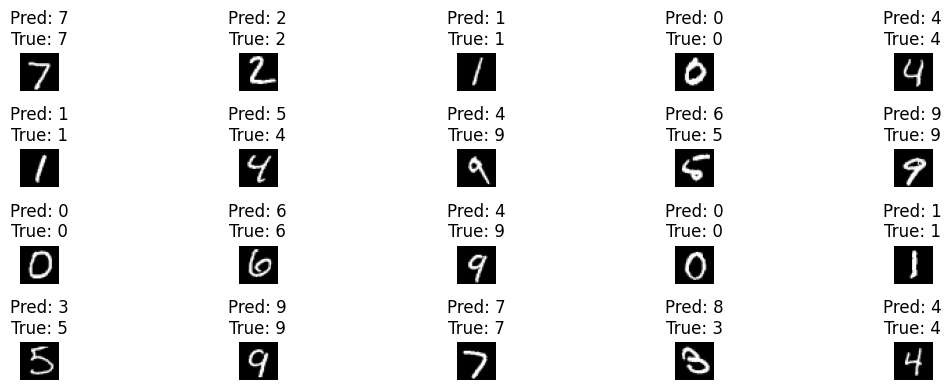

In [71]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [72]:
# Get one batch from the validation data
images, labels = next(iter(val_data))

# Print the shape of the images tensor
print("Shape of images in a batch:", images.shape)
patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
embedded_data = patch_embed(images)
embedded_data = embedded_data.flatten(2)
embedded_data = embedded_data.transpose(1,2)
print("Shape of embedded data:", embedded_data.shape)
print(torch.randn(1,1,embed_dim).shape)

# You can also print the shape of the labels tensor if you'd like
# print("Shape of labels in a batch:", labels.shape)

Shape of images in a batch: torch.Size([32, 1, 28, 28])
Shape of embedded data: torch.Size([32, 16, 16])
torch.Size([1, 1, 16])
